In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ase 

In [2]:
filename = "aims.out"
dbname = "Au_C_final_E_per_atom.db"
n_files = int(80)
emin=-71078.5975710996
#cohesive_E_Au=-3042
metadata={}
metadata["reference"]="DFT/PBE"
metadata["units"]={}
metadata["units"]["energy"]="eV"
metadata["units"]["forces"]="eV/A"
metadata["units"]["geometries"]="A"

filelist=[]
for i in range(20):
    filelist.append(50)
for i in range(10):
    filelist.append(45)
for i in range(10):
    filelist.append(40)
for i in range(10):
    filelist.append(35)
for i in range(10):
    filelist.append(30)
for i in range(10):
    filelist.append(25)
for i in range(5):
    filelist.append(20)
for i in range(5):
    filelist.append(15)
    
min_es={}
min_es[15]=-8745571.265778661--105.17953879
min_es[20]=-11423833.251200577-
min_es[25]=-0
min_es[30]=-16780358.699864034
min_es[35]=-19458623.9505045
min_es[40]=-22136885.150072295
min_es[45]=-24815148.898557194
min_es[50]=-27493411.408611763

In [3]:
def parse_aims_file(filename,natoms,nAu):
    #filename =  '/storage/chem/mssdjc/DB/Shay_Transform/001/aims.out'
    #filename = argv[1]
    #units: energy [eV], forces [eV/A], geometry [A]
    #PBE atomic_zora no PBC
    file = open(filename,"r").readlines()
    atypes=[]
    all_force_mask=[]
    geoms = []
    force_index=[]
    all_force_index=[]
    energy=[]
    forces=[]
    vdwforces=[]
    hirshfeld_volumes=[]
    for l,line in enumerate(file):
        #get first structure
        if "Atomic structure:" in line:
            iatom=-1
            geom=[]
            atypes=[]
            for natom in range(natoms):
                iatom+=1
                atomline=file[l+natom+2].split()
                atypes.append(atomline[3])
                if atomline[3]=="C":
                    geom.append([float(atomline[4]),float(atomline[5]),float(atomline[6])])
                else:
                    force_index.append(iatom)
                    geom.append([float(atomline[4]),float(atomline[5]),float(atomline[6])])
            all_force_index.append(force_index)
            #all_atypes.append(atypes)
            geoms.append(ase.atoms.Atoms(atypes,np.array(geom)))
            break
    file = open(filename,"r").readlines()
    for l,line in enumerate(file):
        index = -1
        geom_index = 0
        force_mask = np.zeros((natoms,3))
        if "Updated atomic structure:" in line:
            geom_index+=1
            iatom=-1
            geom=[]
            force_index=[]
            atypes=[]
            for natom in range(natoms):
                iatom+=1
                atomline=file[l+natom+2].split()
                atypes.append(atomline[4])
                if atomline[4]=="C":
                    geom.append([float(atomline[1]),float(atomline[2]),float(atomline[3])])
                else:
                    force_index.append(iatom)
                    geom.append([float(atomline[1]),float(atomline[2]),float(atomline[3])])
            all_force_index.append(np.array(force_index))
            geoms.append(ase.atoms.Atoms(atypes,np.array(geom)))
          
        ############################################################################
        #########Get forces, van der waals forces, and hirshfeld volumes############
        ############################################################################
        if "Performing Hirshfeld analysis of fragment charges" in line:
            hirshfeld_volume=np.zeros((natoms))
            hirshfeld_volume2=np.zeros((natoms))
            vdw=np.zeros((natoms,3))
            f=np.zeros((natoms,3))
            for natom in range(natoms):
                s=file[l+natom*10+5].split()
                hirshfeld_volume[natom]=float(s[4])
                vdwforce = file[l+natoms*10+35+natom*8].split()
                hirshfeld_volume2[natom] = float(file[l+natom*10+4].split()[5])
                sforce=file[l+natoms*10+37+natom*8].split()

                f[natom][0]=float(sforce[4])
                f[natom][1]=float(sforce[5])
                f[natom][2]=float(sforce[6])
                vdw[natom][0]=float(vdwforce[4])
                vdw[natom][1]=float(vdwforce[5])
                vdw[natom][2]=float(vdwforce[6])
                                
            hirshfeld_volumes.append(hirshfeld_volume/hirshfeld_volume2)
            vdwforces.append(vdw)
            forces.append(f)
        ############################################################################
        #########Get total energies and vdw correction to energies  ################
        ############################################################################        
        if "Libmbd: Evaluated energy:" in line: 
            ener_vdw_corr = float(file[l+8].split()[7])
            total_ener = float(file[l+12].split()[9])
            energy_vdw_free = total_ener-ener_vdw_corr
            #3rd entry in line in H
            #+7 lines entry 7
            #and then +12 lines entry 9
            energy.append(energy_vdw_free)
    return energy,forces,vdwforces,hirshfeld_volumes,geoms

In [4]:
folders= [15,20,25,30,35,40,45,50]
natoms = [701,706,711,716,721,726,731,736]
path = "/storage/chem/mssdjc/Data_Shay/"

all_energy=[]
all_forces=[]
atoms_buffer=[]
property_buffer=[]
all_atypes=[]
all_geoms=[]
all_vdw=[]
all_hirshfeld=[]
n_steps = []
for index,folder in enumerate(folders):
    for i in range(20):
        try:
            filename="%s/%s/%03d/aims.out" %(path,folder,i)
            file = open(filename,"r").readlines()
            print("Enter folder %s/%03d"%(folder,i))
            energy,forces,vdw,hirshfeld,geoms = parse_aims_file(filename,natoms[index],folder)
            n_steps.append((len(energy),folder))
            
            for step in range(len(energy)):
                all_energy.append(energy[step])
                all_forces.append(forces[step])
                all_geoms.append(geoms[step])
                all_hirshfeld.append(hirshfeld[step])
                all_vdw.append(vdw[step])
        except IOError:
            pass #print("H")


Enter folder 15/001
Enter folder 15/002
Enter folder 15/003
Enter folder 15/004
Enter folder 15/005
Enter folder 20/001
Enter folder 20/002
Enter folder 20/003
Enter folder 20/004
Enter folder 30/001
Enter folder 30/002
Enter folder 30/003
Enter folder 30/005
Enter folder 30/006
Enter folder 30/007
Enter folder 30/008
Enter folder 30/009
Enter folder 35/002
Enter folder 35/003
Enter folder 35/004
Enter folder 35/005
Enter folder 35/006
Enter folder 35/007
Enter folder 35/008
Enter folder 35/009
Enter folder 35/010
Enter folder 40/001
Enter folder 40/002
Enter folder 40/003
Enter folder 40/004
Enter folder 40/005
Enter folder 40/007
Enter folder 40/008
Enter folder 40/009
Enter folder 40/010
Enter folder 45/001
Enter folder 45/002
Enter folder 45/003
Enter folder 45/004
Enter folder 45/005
Enter folder 45/006
Enter folder 45/007
Enter folder 45/008
Enter folder 45/009
Enter folder 45/010
Enter folder 50/001
Enter folder 50/002
Enter folder 50/003
Enter folder 50/004
Enter folder 50/005


In [7]:
np.savez("geoms.npz",all_geoms)
np.savez("vdw.npz",all_vdw)
np.savez("forces.npz",all_forces)
np.savez("hirshfeld.npz",all_hirshfeld)
np.savez("energy.npz",all_energy)

In [8]:
print(all_hirshfeld[0].shape)
p=[]
for i in range(len(all_hirshfeld)):
    for j in range(len(all_hirshfeld[i])):
        p.append(1/all_hirshfeld[i][j])

(701,)


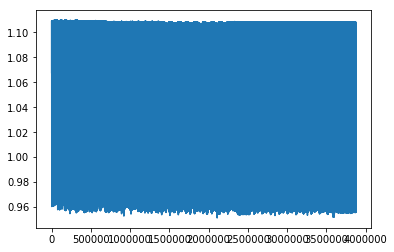

In [9]:
plt.plot(p)

In [21]:
print(len(n_steps))
print(len(all_energy))

energy={}
index=-1
for i,j in enumerate(folders):
    energy[j]=[]
for i in range(len(n_steps)):
    for j in range((n_steps[i][0])):
        index+=1
        energy[n_steps[i][1]].append(all_energy[index]-EC*686-EAu*(n_steps[i][1]))#-min_es[n_steps[i][1]])
    

63
5379


In [22]:
ener_new=[]
for i,j in enumerate(folders):
    for k in range(len(energy[j])):
        ener_new.append(energy[j][k])
ener_new=np.array(ener_new)

5379


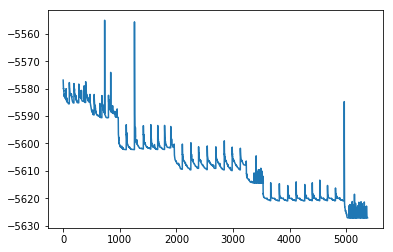

In [23]:
print(len(ener_new))
plt.plot(ener_new)

-5605.831034963152


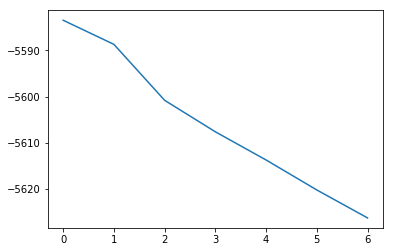

In [18]:
mean_ener=[]
EC=-71078.5975710996
mean = -558114.667915642
EAu=-535651.056128141
EC=-1027.863971797

for i,j in enumerate(folders):
    if j ==25:
        pass
    else:
        mean_ener.append((np.mean(energy[j])-EC*686-EAu*(j)))

mean_ener=np.array(mean_ener)
print(np.mean(mean_ener))
plt.plot(mean_ener)
scale_ener = np.mean(mean_ener)

In [24]:
ener_scaled = []
index=-1
EC=0
h_new=[]
mask = {}
forces_final=[]
for i,j in enumerate(folders):
    mask[j]=np.ones((natoms[i],3))
    print(np.sum(mask[j]))
for i in range(len(n_steps)):
    for j in range((n_steps[i][0])):
        index+=1
        #ener_scaled.append((all_energy[index]-EC-scale_ener*(n_steps[i][1])))
        forces_final.append(((all_forces[index]-all_vdw[index])))
forces_final = np.array(forces_final)
print(forces_final[0][680:])
#m=np.mean(ener_scaled)
#print(m)
1.78777002e-03*27.211
#ener_scaled=ener_scaled-m

2103.0
2118.0
2133.0
2148.0
2163.0
2178.0
2193.0
2208.0
[[-1.0833987e+00  5.8984648e+00  6.3090200e-03]
 [-3.1144915e+00 -3.1065801e+00 -1.6867770e-01]
 [-4.0479508e+00 -8.1417700e-02 -4.4996220e-01]
 [ 5.1077670e-01  4.7115376e+00  1.0677480e-01]
 [ 1.2152180e-01 -9.9321020e-01  2.8199630e-01]
 [ 3.7136628e+00 -3.7117587e+00  2.0828900e-01]
 [ 5.5464470e-01 -8.9567060e-01  1.5762680e-01]
 [ 2.2307740e-01  2.7536700e-01 -1.3876834e+00]
 [ 5.2386520e-01  1.4354473e-01 -2.7458910e-01]
 [-5.9017160e-01 -4.4717720e-01 -3.3487110e-01]
 [-5.4321110e-01 -1.4977177e+00  1.0246010e-01]
 [-9.1338270e-01  2.8349450e-01 -1.1221633e+00]
 [-7.3387320e-01  1.6601140e-01  1.0438791e+00]
 [-1.2284540e-01  1.6453040e-01 -1.0789003e+00]
 [ 6.1365690e-01  1.2884139e+00 -2.4312750e-01]
 [-1.1387710e-01 -6.9673602e-01  3.7560870e-01]
 [ 1.6803520e-01  3.5714570e-01  6.4497820e-01]
 [-4.9734343e-01 -1.3706727e+00  3.2543930e-01]
 [ 7.4728540e-01  9.5718140e-01  6.6579360e-01]
 [ 8.0551870e-01  1.6245500e-03 

0.04864701001422

In [25]:
print(np.min(ener_scaled),np.max(ener_scaled))
plt.plot(ener_scaled)

ValueError: zero-size array to reduction operation minimum which has no identity

In [26]:
0.4*27.211

10.8844

In [27]:
h=[]
f=[]
f2=[]
f3=[]
indices_sorted=[]
for i in range(len(all_forces)):
    for j in range(len(all_forces[i])):
        for xyz in range(3):
            f.append(forces_final[i][j][xyz])
            f3.append(all_vdw[i][j][xyz])
            if np.abs(forces_final[i][j][xyz])>=11:
                if i in indices_sorted:
                    pass
                else:
                    indices_sorted.append(i)
            else:
                f2.append(forces_final[i][j][xyz])
        h.append(all_hirshfeld[i][j])


[52, 323, 371, 733, 840, 1260, 1261, 1262, 4967, 4968, 4969]
11
0.9280603237896642
(701,)


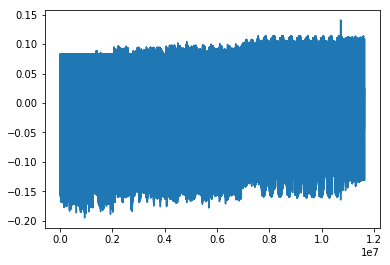

In [28]:
#plt.plot(f2)
plt.plot(f3)
print(indices_sorted)
print(len(indices_sorted))
print(np.mean(h))
print(all_hirshfeld[0].shape)

In [38]:
new_data={}
index=0
new_atoms = []
print(len(ener_scaled))
for i in range(len(ener_new)):
        new_data[i]={}
        #energy
        ener=ener_new[i]-mean_ener
        e=np.zeros((1,1))
        e[0]=ener
        new_data[i]["energy"]=np.array(e).reshape((1))
        
        #forces
        new_data[i]["forces"]=forces_final[i]
        
        #hirshfeld
        new_data[i]["hirshfeld_volumes"] = all_hirshfeld[i]
        
        index+=1
        new_atoms.append(all_geoms[i])

0


In [39]:
print(len(new_data))
print(len(new_atoms))
print(forces_final[0])

5379
5379
[[ 2.7750946e+00 -1.8421070e-01  2.2122122e+00]
 [-1.8647705e-01  4.0851852e+00  1.2650144e+00]
 [-1.9295612e+00  4.2306010e+00  2.5463292e+00]
 ...
 [ 7.4728540e-01  9.5718140e-01  6.6579360e-01]
 [ 8.0551870e-01  1.6245500e-03 -1.6103900e-01]
 [ 4.8647700e-02  1.2186044e+00  4.7728810e-01]]


In [40]:
import schnetpack as spk 
dbold = spk.data.AtomsData("/home/chem/mssdjc/software/SchNetPack/databases/Au_C_molec_sorted.db")
metaold = dbold.get_metadata()
print(metaold)

{'ref': 'Reference: DFT/PBE, no PBC, Au on C', 'mean_energy': {'15': -8745571.26577866, '20': -11423833.2512006, '30': -16780358.699864, '35': -19458623.9505045, '40': -22136885.150072295, '45': -24815148.898557194, '50': -27493411.408611763}, 'units': {'energy': 'eV', 'R': 'A', 'forces': 'eV/A'}, 'indices_not_used': [733, 733, 1260, 1261, 1262, 4967, 4968, 20, 52, 289, 323, 371, 522, 526, 648, 689, 805, 840, 913, 954, 984, 1127, 1264, 1276, 1301, 1681, 1803, 1911, 2257, 3235, 3236, 3246, 3410, 3531, 4280, 4413, 4969, 4970, 5107, 5126, 5336, 5337]}


In [6]:

EAu=-535651.056128141
EC=-1027.863971797
mean_ener=-5605.831034963152
metadata={}
metadata["indices_not_used"]=[52, 323, 371, 733, 840, 1260, 1261, 1262, 4967, 4968, 4969]
metadata["Info"]="Energy = Energy (Vdw-free)- N_Au*E_Au(ad)-N_C*E_C(ad)-E_mean"
metadata["E_C"]=EC
metadata["E_Au"]=EAu
metadata["E_mean"]=mean_ener
metadata["units"]="eV and eV/A"
print(metadata)

{'indices_not_used': [52, 323, 371, 733, 840, 1260, 1261, 1262, 4967, 4968, 4969], 'Info': 'Energy = Energy (Vdw-free)- N_Au*E_Au(ad)-N_C*E_C(ad)-E_mean', 'E_C': -1027.863971797, 'E_Au': -535651.056128141, 'E_mean': -5605.831034963152, 'units': 'eV and eV/A'}


In [43]:
from ase.db import connect
eplot=[]
dbname="/home/chem/mssdjc/software/SchNetPack/databases/Au_C_vdwfree_final.db"
with connect(dbname) as new_conn:
    for idx in range(len(new_data)):
        if idx in indices_sorted:
            pass
        else:
            new_conn.write(new_atoms[idx],data=new_data[idx])


In [7]:
#set meta data
from ase.db import connect
dbname="/home/chem/mssdjc/software/SchNetPack/databases/Au_C_vdwfree_final.db"

dbn = connect(dbname)
print(len(dbn))
dbn.metadata = metadata
dbn.set_metadata=metadata


5368


In [17]:
dbn.set_metadata=metadata
import schnetpack as spk
db=spk.data.AtomsData(dbname)
spk.data.AtomsData(dbname).set_metadata=metadata
db.get_metadata

<bound method AtomsData.get_metadata of <schnetpack.data.atoms.AtomsData object at 0x2b58d7ebab38>>

nan


/home/chem/mssdjc/software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chem/mssdjc/software/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


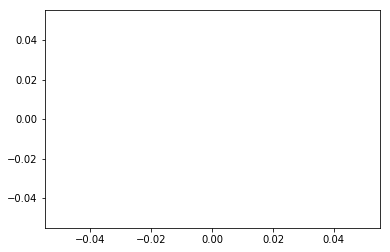

In [45]:
plt.plot(eplot-mean_ener)
mean_ener=np.mean(eplot)
print(mean_ener)

In [18]:
metadata


{'indices_not_used': [52,
  323,
  371,
  733,
  840,
  1260,
  1261,
  1262,
  4967,
  4968,
  4969],
 'Info': 'Energy = Energy (Vdw-free)- N_Au*E_Au(ad)-N_C*E_C(ad)-E_mean',
 'E_C': -1027.863971797,
 'E_Au': -535651.056128141,
 'E_mean': -5605.831034963152,
 'units': 'eV and eV/A'}